# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

In [1]:
pip install imageio

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install pillow

You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [3]:
# mount google drive.
# from google.colab import drive
# drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
# Unzip the dataset
#!unzip "/content/gdrive/MyDrive/Project_data.zip" > /dev/null

replace Project_data/train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [15]:
# # Defining the path for train and test images
# import pathlib
# data_dir_train = pathlib.Path("/content/Project_data/train")
# data_dir_val = pathlib.Path("/content/Project_data/val")

In [3]:
import numpy as np
import os
from PIL import Image
import imageio
import datetime
import os

We set the random seed so that the results don't vary drastically.

In [4]:
np.random.seed(30)
import random as rn
rn.seed(30)
from keras import backend as K
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [7]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())
batch_size = 32


In [12]:
num_images = train_doc.shape[0]
print(f'Number of images in Train: {num_images}')
num_images = val_doc.shape[0]
print(f'Number of images in validation: {num_images}')

Number of images in Train: 663
Number of images in validation: 100


## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [15]:
def generator(source_path, folder_list, batch_size, is_train=False, augmentation=False, debug=False):
    print('Source path =', source_path, '; batch size =', batch_size)
    img_idx = [7,9,11,13,14,15,16,18,19,21,22,23,24,25,26]
    x = len(img_idx)
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t) // batch_size
        for batch in range(num_batches):
            batch_data = np.zeros((batch_size, x, 100, 100, 3))  # Initialize batch data
            batch_labels = np.zeros((batch_size, 5))  # Initialize batch labels

            for folder in range(batch_size):
                folder_path = os.path.join(source_path, t[folder + (batch * batch_size)].strip().split(';')[0])
                if not os.path.exists(folder_path):
                    print(f"Folder not found: {folder_path}")
                    continue

                imgs = sorted(os.listdir(folder_path))  # Ensure images are in sorted order
                for idx, item in enumerate(img_idx):
                    img_path = os.path.join(folder_path, imgs[item])
                    if not os.path.isfile(img_path):
                        print(f"Image file not found: {img_path}")
                        continue

                    image = Image.open(img_path).resize((100, 100))  # Resize image
                    image = np.array(image).astype(np.float32)  # Convert to numpy array

                    if is_train and augmentation:
                        # Add image augmentation here (e.g., random flips, rotations)
                        # For simplicity, we'll skip augmentation in this example
                        pass

                    batch_data[folder, idx] = image / 255.0  # Normalize image

                label = int(t[folder + (batch * batch_size)].strip().split(';')[2])
                batch_labels[folder, label] = 1

            if debug:
                print(f"Batch data shape: {batch_data.shape}")
                print(f"Batch labels shape: {batch_labels.shape}")

            yield batch_data, batch_labels

        # Handle remaining data points
        if len(t) % batch_size != 0:
            batch_data = np.zeros((len(t) % batch_size, x, 100, 100, 3))
            batch_labels = np.zeros((len(t) % batch_size, 5))

            for folder in range(len(t) % batch_size):
                folder_path = os.path.join(source_path, t[folder + (num_batches * batch_size)].strip().split(';')[0])
                if not os.path.exists(folder_path):
                    print(f"Folder not found: {folder_path}")
                    continue

                imgs = sorted(os.listdir(folder_path))  # Ensure images are in sorted order
                for idx, item in enumerate(img_idx):
                    img_path = os.path.join(folder_path, imgs[item])
                    if not os.path.isfile(img_path):
                        print(f"Image file not found: {img_path}")
                        continue

                    image = Image.open(img_path).resize((100, 100))  # Resize image
                    image = np.array(image).astype(np.float32)  # Convert to numpy array

                    if is_train and augmentation:
                        # Add image augmentation here (e.g., random flips, rotations)
                        # For simplicity, we'll skip augmentation in this example
                        pass

                    batch_data[folder, idx] = image / 255.0  # Normalize image

                label = int(t[folder + (num_batches * batch_size)].strip().split(';')[2])
                batch_labels[folder, label] = 1

            yield batch_data, batch_labels



Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [16]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 50
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 50


In [17]:
test_gen = generator(train_path, train_doc, 1, is_train=True, augmentation=True, debug=True)
batch_data, batch_labels = next(test_gen)

Source path = /home/datasets/Project_data/train ; batch size = 1
Batch data shape: (1, 15, 100, 100, 3)
Batch labels shape: (1, 5)


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [19]:
from keras.models import Sequential, Model
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv3D, MaxPooling3D,Dropout
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras import optimizers

img_idx = [7,9,11,13,14,15,16,18,19,21,22,23,24,25,26]
x = len(img_idx)
#write your model here
Input_shape = (x, 100, 100, 3)
model = Sequential()
model.add(Conv3D(32, (3,3,3), padding='same',
                 input_shape=Input_shape))
#model.add(Conv3D(32, kernel_size=(3, 3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=sample_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(32, (3, 3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.5))

model.add(Conv3D(64, (3, 3,3), padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(Conv3D(64, (3, 3,3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling3D(pool_size=(2, 2,2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))

2024-07-29 08:25:54.554734: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-07-29 08:25:54.554822: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:41:00.0, compute capability: 7.5


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [20]:
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 15, 100, 100, 32)  2624      
                                                                 
 activation (Activation)     (None, 15, 100, 100, 32)  0         
                                                                 
 batch_normalization (BatchN  (None, 15, 100, 100, 32)  128      
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 13, 98, 98, 32)    27680     
                                                                 
 activation_1 (Activation)   (None, 13, 98, 98, 32)    0         
                                                                 
 batch_normalization_1 (Batc  (None, 13, 98, 98, 32)   128       
 hNormalization)                                        

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [21]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [22]:
from datetime import datetime
curr_dt_time = datetime.now()
model_name = 'gesture_model_1' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Create directory for saving models if it doesn't exist
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define the file path for saving model checkpoints
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# Define ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch'  # Updated from 'period' to 'save_freq'
)

# Define ReduceLROnPlateau callback
LR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=0,
    mode='auto',
    min_delta=1e-4,  # Updated from 'epsilon' to 'min_delta'
    cooldown=0,
    min_lr=0
)

callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [23]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [ ]:
# steps_per_epoch = (num_train_sequences + batch_size - 1) // batch_size
# validation_steps = (num_val_sequences + batch_size - 1) // batch_size

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [24]:
history=model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=num_epochs,
    verbose=1,
    callbacks=callbacks_list,
    validation_data=val_generator,
    validation_steps=validation_steps,
    class_weight=None,
    workers=1,
    initial_epoch=0
)


Source path = /home/datasets/Project_data/train ; batch size = 32
Epoch 1/50


2024-07-29 08:26:29.124016: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


21/21 [==============================] - ETA: 0s - loss: 39.7065 - categorical_accuracy: 0.3741Source path = /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 280.80557, saving model to gesture_model_1_2024-07-2908_26_15.651035/model-00001-39.70653-0.37406-280.80557-0.17000.h5
21/21 [==============================] - 47s 2s/step - loss: 39.7065 - categorical_accuracy: 0.3741 - val_loss: 280.8056 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 6.8864 - categorical_accuracy: 0.6048
Epoch 00002: val_loss improved from 280.80557 to 61.34480, saving model to gesture_model_1_2024-07-2908_26_15.651035/model-00002-6.88639-0.60483-61.34480-0.21000.h5
21/21 [==============================] - 37s 2s/step - loss: 6.8864 - categorical_accuracy: 0.6048 - val_loss: 61.3448 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 3.1

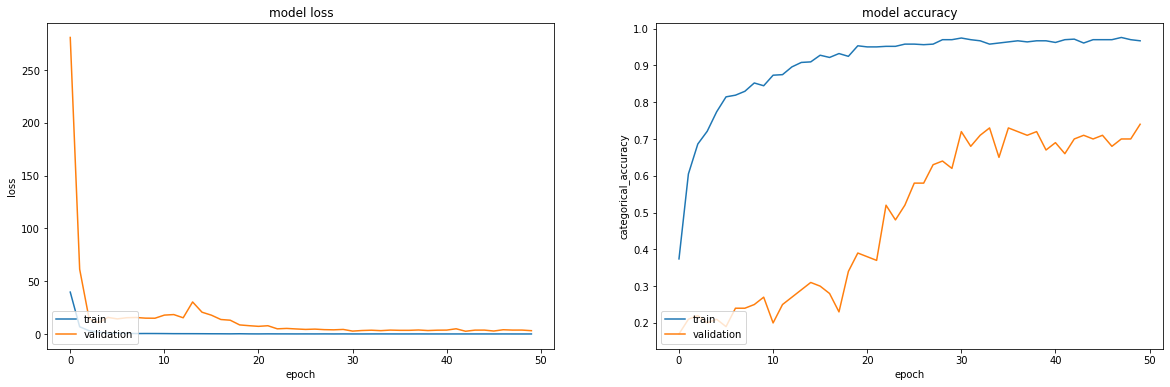

In [25]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history.history['loss'])
ax1 = plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history.history['categorical_accuracy'])
ax2 = plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')


In [26]:
# Extract the lists of loss and accuracy values
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['categorical_accuracy']
val_accuracy = history.history['val_categorical_accuracy']

# Print training and validation loss values
print("Training Loss per Epoch:")
for epoch, loss in enumerate(train_loss, start=1):
    print(f"Epoch {epoch}: Training Loss = {loss:.4f}")

print("\nValidation Loss per Epoch:")
for epoch, loss in enumerate(val_loss, start=1):
    print(f"Epoch {epoch}: Validation Loss = {loss:.4f}")

# Print training and validation accuracy values
print("\nTraining Accuracy per Epoch:")
for epoch, accuracy in enumerate(train_accuracy, start=1):
    print(f"Epoch {epoch}: Training Accuracy = {accuracy:.4f}")

print("\nValidation Accuracy per Epoch:")
for epoch, accuracy in enumerate(val_accuracy, start=1):
    print(f"Epoch {epoch}: Validation Accuracy = {accuracy:.4f}")

Training Loss per Epoch:
Epoch 1: Training Loss = 39.7065
Epoch 2: Training Loss = 6.8864
Epoch 3: Training Loss = 3.1396
Epoch 4: Training Loss = 1.8465
Epoch 5: Training Loss = 0.9352
Epoch 6: Training Loss = 0.7678
Epoch 7: Training Loss = 0.6717
Epoch 8: Training Loss = 0.4650
Epoch 9: Training Loss = 0.5061
Epoch 10: Training Loss = 0.4890
Epoch 11: Training Loss = 0.4420
Epoch 12: Training Loss = 0.3624
Epoch 13: Training Loss = 0.3492
Epoch 14: Training Loss = 0.3386
Epoch 15: Training Loss = 0.3104
Epoch 16: Training Loss = 0.2597
Epoch 17: Training Loss = 0.2382
Epoch 18: Training Loss = 0.1855
Epoch 19: Training Loss = 0.2820
Epoch 20: Training Loss = 0.1604
Epoch 21: Training Loss = 0.1238
Epoch 22: Training Loss = 0.1826
Epoch 23: Training Loss = 0.1507
Epoch 24: Training Loss = 0.1382
Epoch 25: Training Loss = 0.1111
Epoch 26: Training Loss = 0.1288
Epoch 27: Training Loss = 0.1102
Epoch 28: Training Loss = 0.1426
Epoch 29: Training Loss = 0.0932
Epoch 30: Training Loss = 

## Model 2

In [28]:
#write your model here
from keras.models import Sequential, Model
from keras.layers import Conv2D,MaxPooling2D,ConvLSTM2D,GlobalAveragePooling2D
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, Activation, Dropout, LSTM, Bidirectional


img_idx = [7,9,11,13,14,15,16,18,19,21,22,23,24,25,26]
x = len(img_idx)
#write your model here
Input_shape_1 = (x, 100, 100, 3)

model = Sequential()
model.add(TimeDistributed(
    Conv2D(8, (3,3), activation='relu'), input_shape=Input_shape_1)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Conv2D(16, (3,3), activation='relu'))
)
model.add(BatchNormalization())
model.add(
    ConvLSTM2D(8, kernel_size = 3, return_sequences=False)
)
model.add(BatchNormalization())
model.add(TimeDistributed(
    Dense(64, activation='relu'))
)
model.add(BatchNormalization())
model.add(GlobalAveragePooling2D())
model.add(Dense(64, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 98, 98, 8)    224       
 ibuted)                                                         
                                                                 
 batch_normalization_4 (Batc  (None, 15, 98, 98, 8)    32        
 hNormalization)                                                 
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 96, 96, 16)   1168      
 tributed)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 15, 96, 96, 16)   64        
 hNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 94, 94, 8)        

In [29]:
#optimiser = Keras.optimizers.Adam(lr=0.001)
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 15, 98, 98, 8)    224       
 ibuted)                                                         
                                                                 
 batch_normalization_4 (Batc  (None, 15, 98, 98, 8)    32        
 hNormalization)                                                 
                                                                 
 time_distributed_1 (TimeDis  (None, 15, 96, 96, 16)   1168      
 tributed)                                                       
                                                                 
 batch_normalization_5 (Batc  (None, 15, 96, 96, 16)   64        
 hNormalization)                                                 
                                                                 
 conv_lstm2d (ConvLSTM2D)    (None, 94, 94, 8)        

In [30]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [31]:
from datetime import datetime
curr_dt_time = datetime.now()
model_name = 'gesture_model_2' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Create directory for saving models if it doesn't exist
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define the file path for saving model checkpoints
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# Define ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch'  # Updated from 'period' to 'save_freq'
)

# Define ReduceLROnPlateau callback
LR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=0,
    mode='auto',
    min_delta=1e-4,  # Updated from 'epsilon' to 'min_delta'
    cooldown=0,
    min_lr=0
)

callbacks_list = [checkpoint, LR]

In [32]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [33]:
history2=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_483/3664631933.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path = /home/datasets/Project_data/train ; batch size = 32
Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 1.5819 - categorical_accuracy: 0.2247Source path = /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.60951, saving model to gesture_model_2_2024-07-2909_10_31.469335/model-00001-1.58189-0.22474-1.60951-0.18000.h5
21/21 [==============================] - 37s 2s/step - loss: 1.5819 - categorical_accuracy: 0.2247 - val_loss: 1.6095 - val_categorical_accuracy: 0.1800 - lr: 0.0100
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.5240 - categorical_accuracy: 0.3273
Epoch 00002: val_loss improved from 1.60951 to 1.60677, saving model to gesture_model_2_2024-07-2909_10_31.469335/model-00002-1.52400-0.32730-1.60677-0.19000.h5
21/21 [==============================] - 34s 2s/step - loss: 1.5240 - categorical_accuracy: 0.3273 - val_loss: 1.6068 - val_categorical_accuracy: 0.1900 - lr: 0.0100
Epoch 3/

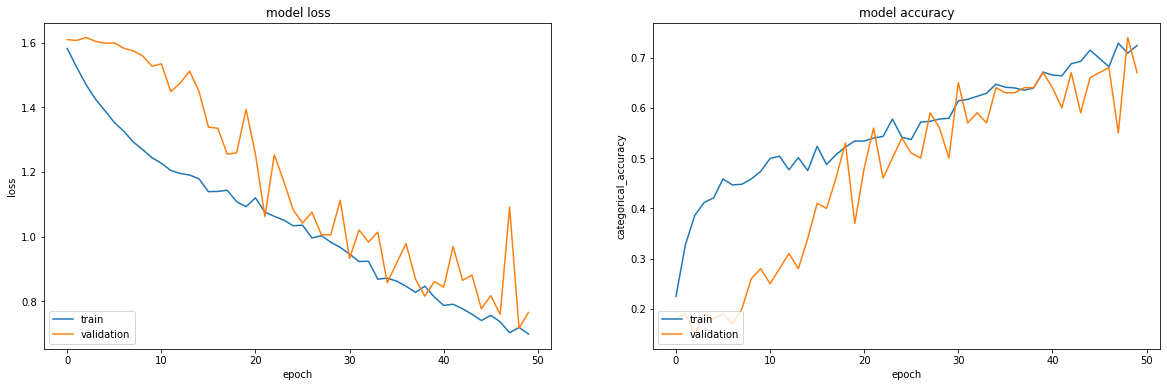

In [34]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history2.history['loss'])
ax1 = plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history2.history['categorical_accuracy'])
ax2 = plt.plot(history2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')


In [35]:
# Extract the lists of loss and accuracy values
train_loss = history2.history['loss']
val_loss = history2.history['val_loss']
train_accuracy = history2.history['categorical_accuracy']
val_accuracy = history2.history['val_categorical_accuracy']

# Print training and validation loss values
print("Training Loss per Epoch:")
for epoch, loss in enumerate(train_loss, start=1):
    print(f"Epoch {epoch}: Training Loss = {loss:.4f}")

print("\nValidation Loss per Epoch:")
for epoch, loss in enumerate(val_loss, start=1):
    print(f"Epoch {epoch}: Validation Loss = {loss:.4f}")

# Print training and validation accuracy values
print("\nTraining Accuracy per Epoch:")
for epoch, accuracy in enumerate(train_accuracy, start=1):
    print(f"Epoch {epoch}: Training Accuracy = {accuracy:.4f}")

print("\nValidation Accuracy per Epoch:")
for epoch, accuracy in enumerate(val_accuracy, start=1):
    print(f"Epoch {epoch}: Validation Accuracy = {accuracy:.4f}")

Training Loss per Epoch:
Epoch 1: Training Loss = 1.5819
Epoch 2: Training Loss = 1.5240
Epoch 3: Training Loss = 1.4702
Epoch 4: Training Loss = 1.4250
Epoch 5: Training Loss = 1.3895
Epoch 6: Training Loss = 1.3531
Epoch 7: Training Loss = 1.3263
Epoch 8: Training Loss = 1.2930
Epoch 9: Training Loss = 1.2692
Epoch 10: Training Loss = 1.2440
Epoch 11: Training Loss = 1.2267
Epoch 12: Training Loss = 1.2045
Epoch 13: Training Loss = 1.1951
Epoch 14: Training Loss = 1.1904
Epoch 15: Training Loss = 1.1786
Epoch 16: Training Loss = 1.1389
Epoch 17: Training Loss = 1.1397
Epoch 18: Training Loss = 1.1432
Epoch 19: Training Loss = 1.1078
Epoch 20: Training Loss = 1.0925
Epoch 21: Training Loss = 1.1197
Epoch 22: Training Loss = 1.0755
Epoch 23: Training Loss = 1.0625
Epoch 24: Training Loss = 1.0510
Epoch 25: Training Loss = 1.0335
Epoch 26: Training Loss = 1.0350
Epoch 27: Training Loss = 0.9958
Epoch 28: Training Loss = 1.0027
Epoch 29: Training Loss = 0.9825
Epoch 30: Training Loss = 0

## Model 3


In [37]:
img_idx = [7,9,11,13,14,15,16,18,19,21,22,23,24,25,26]
x = len(img_idx)
#write your model here
Input_shape = (x, 100, 100, 3)

model = Sequential()

model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=Input_shape))
model.add(Conv3D(64, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Conv3D(128, kernel_size=3, activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Conv3D(256, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(Conv3D(512, kernel_size=(1, 3, 3), activation='relu'))
model.add(MaxPooling3D(pool_size=(1, 2, 2)))
model.add(BatchNormalization())
#model.add(Dropout(0.2))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(5, activation='softmax'))

In [39]:
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_4 (Conv3D)           (None, 13, 98, 98, 32)    2624      
                                                                 
 conv3d_5 (Conv3D)           (None, 11, 96, 96, 64)    55360     
                                                                 
 max_pooling3d_2 (MaxPooling  (None, 5, 48, 48, 64)    0         
 3D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 5, 48, 48, 64)    256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 5, 48, 48, 64)     0         
                                                                 
 conv3d_6 (Conv3D)           (None, 3, 46, 46, 128)   

In [41]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [42]:
from datetime import datetime
curr_dt_time = datetime.now()
model_name = 'gesture_model_3' + '_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Create directory for saving models if it doesn't exist
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define the file path for saving model checkpoints
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# Define ModelCheckpoint callback
checkpoint = ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch'  # Updated from 'period' to 'save_freq'
)

# Define ReduceLROnPlateau callback
LR = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=10,
    verbose=0,
    mode='auto',
    min_delta=1e-4,  # Updated from 'epsilon' to 'min_delta'
    cooldown=0,
    min_lr=0
)

callbacks_list = [checkpoint, LR]

In [43]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [44]:
history3=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,
                    callbacks=callbacks_list, validation_data=val_generator,
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

/tmp/ipykernel_483/2382702115.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history3=model.fit_generator(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1,


Source path = /home/datasets/Project_data/train ; batch size = 32
Epoch 1/50
21/21 [==============================] - ETA: 0s - loss: 1.9017 - categorical_accuracy: 0.3469Source path = /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.59073, saving model to gesture_model_3_2024-07-2909_41_15.860062/model-00001-1.90170-0.34691-1.59073-0.32000.h5
21/21 [==============================] - 45s 2s/step - loss: 1.9017 - categorical_accuracy: 0.3469 - val_loss: 1.5907 - val_categorical_accuracy: 0.3200 - lr: 0.0100
Epoch 2/50
21/21 [==============================] - ETA: 0s - loss: 1.4614 - categorical_accuracy: 0.4615
Epoch 00002: val_loss did not improve from 1.59073
21/21 [==============================] - 33s 2s/step - loss: 1.4614 - categorical_accuracy: 0.4615 - val_loss: 1.6326 - val_categorical_accuracy: 0.2200 - lr: 0.0100
Epoch 3/50
21/21 [==============================] - ETA: 0s - loss: 1.2558 - categorical_accuracy: 0.5249
Epoch 00003:

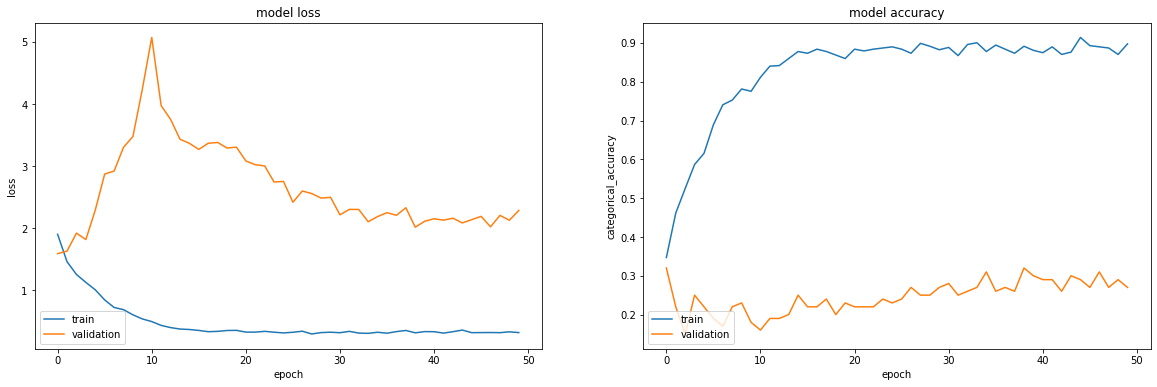

In [45]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,6))
ax1 = plt.subplot(121)
ax1 = plt.plot(history3.history['loss'])
ax1 = plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')
ax2 = plt.subplot(122)
ax2 = plt.plot(history3.history['categorical_accuracy'])
ax2 = plt.plot(history3.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('categorical_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower left')

In [46]:
# Extract the lists of loss and accuracy values
train_loss = history3.history['loss']
val_loss = history3.history['val_loss']
train_accuracy = history3.history['categorical_accuracy']
val_accuracy = history3.history['val_categorical_accuracy']

# Print training and validation loss values
print("Training Loss per Epoch:")
for epoch, loss in enumerate(train_loss, start=1):
    print(f"Epoch {epoch}: Training Loss = {loss:.4f}")

print("\nValidation Loss per Epoch:")
for epoch, loss in enumerate(val_loss, start=1):
    print(f"Epoch {epoch}: Validation Loss = {loss:.4f}")

# Print training and validation accuracy values
print("\nTraining Accuracy per Epoch:")
for epoch, accuracy in enumerate(train_accuracy, start=1):
    print(f"Epoch {epoch}: Training Accuracy = {accuracy:.4f}")

print("\nValidation Accuracy per Epoch:")
for epoch, accuracy in enumerate(val_accuracy, start=1):
    print(f"Epoch {epoch}: Validation Accuracy = {accuracy:.4f}")

Training Loss per Epoch:
Epoch 1: Training Loss = 1.9017
Epoch 2: Training Loss = 1.4614
Epoch 3: Training Loss = 1.2558
Epoch 4: Training Loss = 1.1286
Epoch 5: Training Loss = 1.0089
Epoch 6: Training Loss = 0.8460
Epoch 7: Training Loss = 0.7251
Epoch 8: Training Loss = 0.6894
Epoch 9: Training Loss = 0.6063
Epoch 10: Training Loss = 0.5402
Epoch 11: Training Loss = 0.4978
Epoch 12: Training Loss = 0.4361
Epoch 13: Training Loss = 0.4008
Epoch 14: Training Loss = 0.3774
Epoch 15: Training Loss = 0.3701
Epoch 16: Training Loss = 0.3551
Epoch 17: Training Loss = 0.3347
Epoch 18: Training Loss = 0.3401
Epoch 19: Training Loss = 0.3540
Epoch 20: Training Loss = 0.3565
Epoch 21: Training Loss = 0.3281
Epoch 22: Training Loss = 0.3279
Epoch 23: Training Loss = 0.3405
Epoch 24: Training Loss = 0.3265
Epoch 25: Training Loss = 0.3151
Epoch 26: Training Loss = 0.3256
Epoch 27: Training Loss = 0.3425
Epoch 28: Training Loss = 0.2981
Epoch 29: Training Loss = 0.3206
Epoch 30: Training Loss = 0

In [41]:
import shutil
from google.colab import files

# Path to your directory
directory_path = '/content/gesture_model_1_2024-07-2812_40_44.162586'

# Compress the directory into a zip file
shutil.make_archive('/content/gesture_model_1', 'zip', directory_path)

# Download the zip file
files.download('/content/gesture_model_1.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [42]:

# Define the directory path and the zip file name
directory_path = '/content/gesture_model_2_2024-07-2813_03_58.917446'


# Compress the directory into a zip file
shutil.make_archive('/content/gesture_model_2', 'zip', directory_path)

# Download the zip file
files.download('/content/gesture_model_2.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>